Loading processed data...
✓ Loaded 7488 students
✓ Loaded topic vectors: (7488, 5)
Sampling pairs from 7488 students...
  Total possible pairs: 28,031,328
  Sampling 50,000 random pairs
✓ Created 50,000 pairs

TESTING LABELING METHODS


--- Testing topical method ---
Labeling 50,000 pairs using 'topical' method...
  Labeled 10,000/50,000 pairs...
  Labeled 20,000/50,000 pairs...
  Labeled 30,000/50,000 pairs...
  Labeled 40,000/50,000 pairs...
  Labeled 50,000/50,000 pairs...
✓ Labeled 22,302 valid pairs
Score distribution:
count    22302.000000
mean         0.250176
std          0.184539
min          0.000000
25%          0.037480
50%          0.297778
75%          0.400000
max          0.640000
Name: complementarity_score, dtype: float64

--- Testing engagement method ---
Labeling 50,000 pairs using 'engagement' method...
  Labeled 10,000/50,000 pairs...
  Labeled 20,000/50,000 pairs...
  Labeled 30,000/50,000 pairs...
  Labeled 40,000/50,000 pairs...
  Labeled 50,000/50,000 pairs...

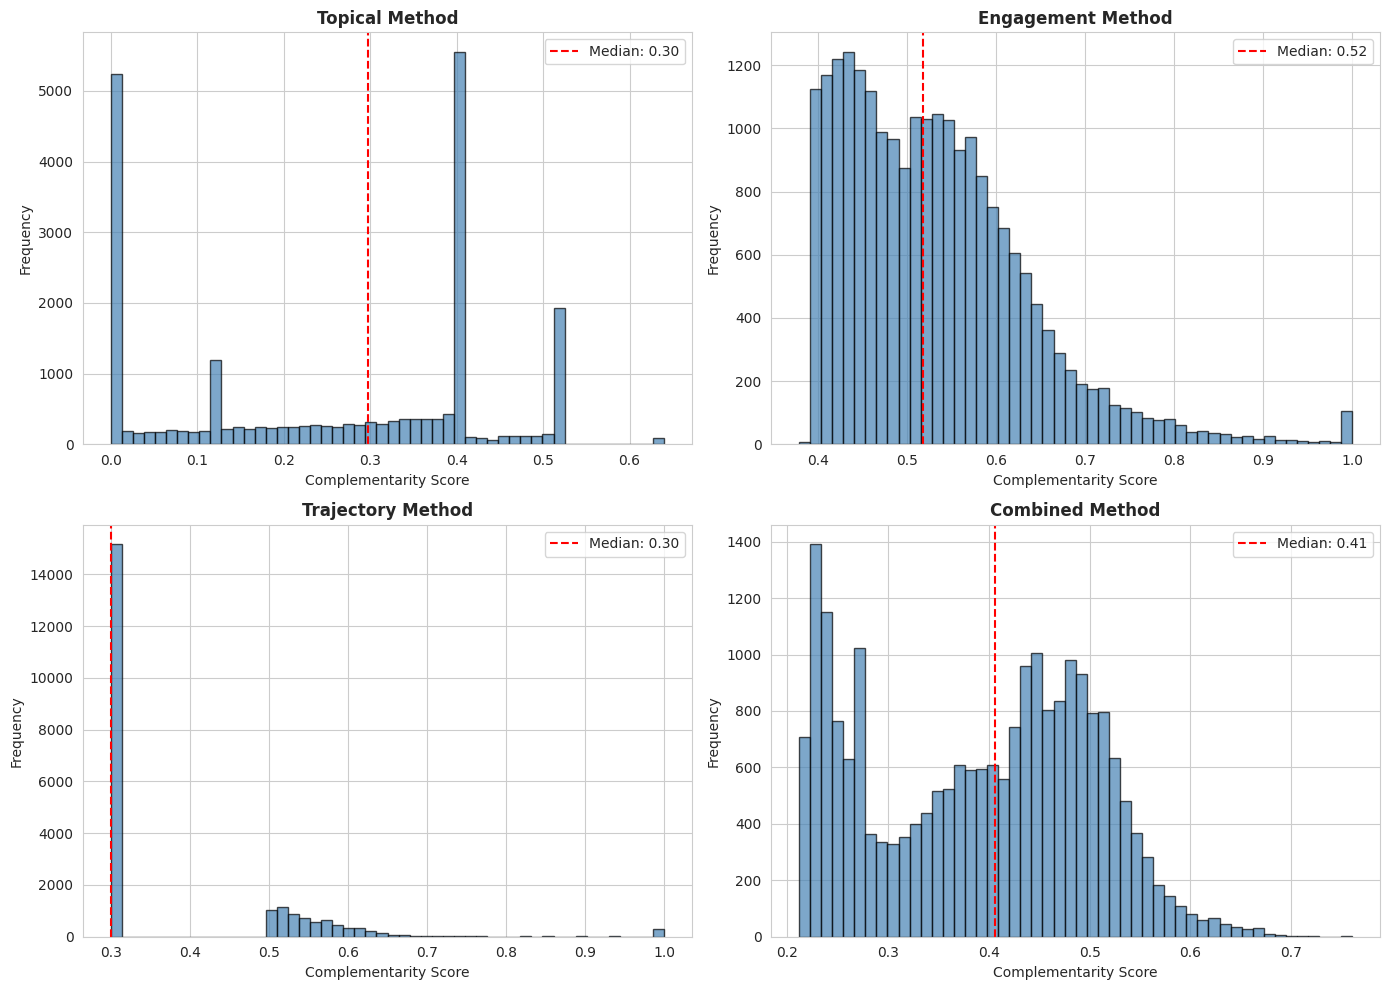


CREATING FINAL LABELS (COMBINED METHOD)


Binary label statistics:
  Threshold (P70): 0.467
  Positive pairs: 6,691 (30.0%)
  Negative pairs: 15,611 (70.0%)


Binary label statistics:
  Threshold (P75): 0.480
  Positive pairs: 5,576 (25.0%)
  Negative pairs: 16,726 (75.0%)


Binary label statistics:
  Threshold (P80): 0.493
  Positive pairs: 4,461 (20.0%)
  Negative pairs: 17,841 (80.0%)


Binary label statistics:
  Threshold (P75): 0.480
  Positive pairs: 5,576 (25.0%)
  Negative pairs: 16,726 (75.0%)


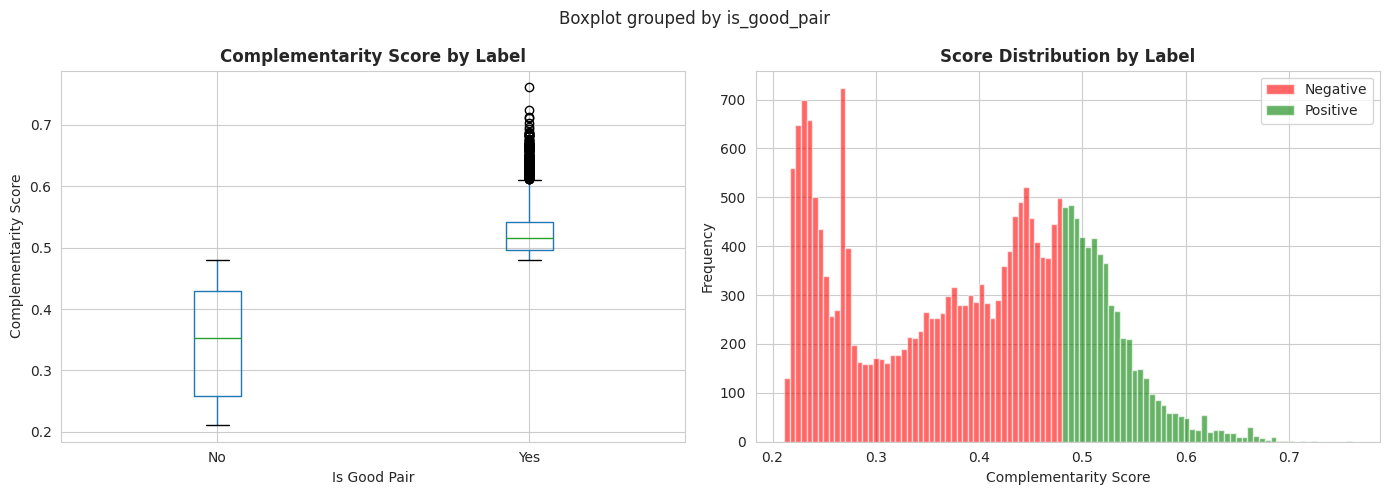


PAIR CHARACTERISTICS ANALYSIS

Average characteristics:
              score_diff  engagement_diff    score_i    score_j
is_good_pair                                                   
0              18.013749         0.770129  70.782444  72.812261
1              18.454736         1.296786  74.787825  76.851894


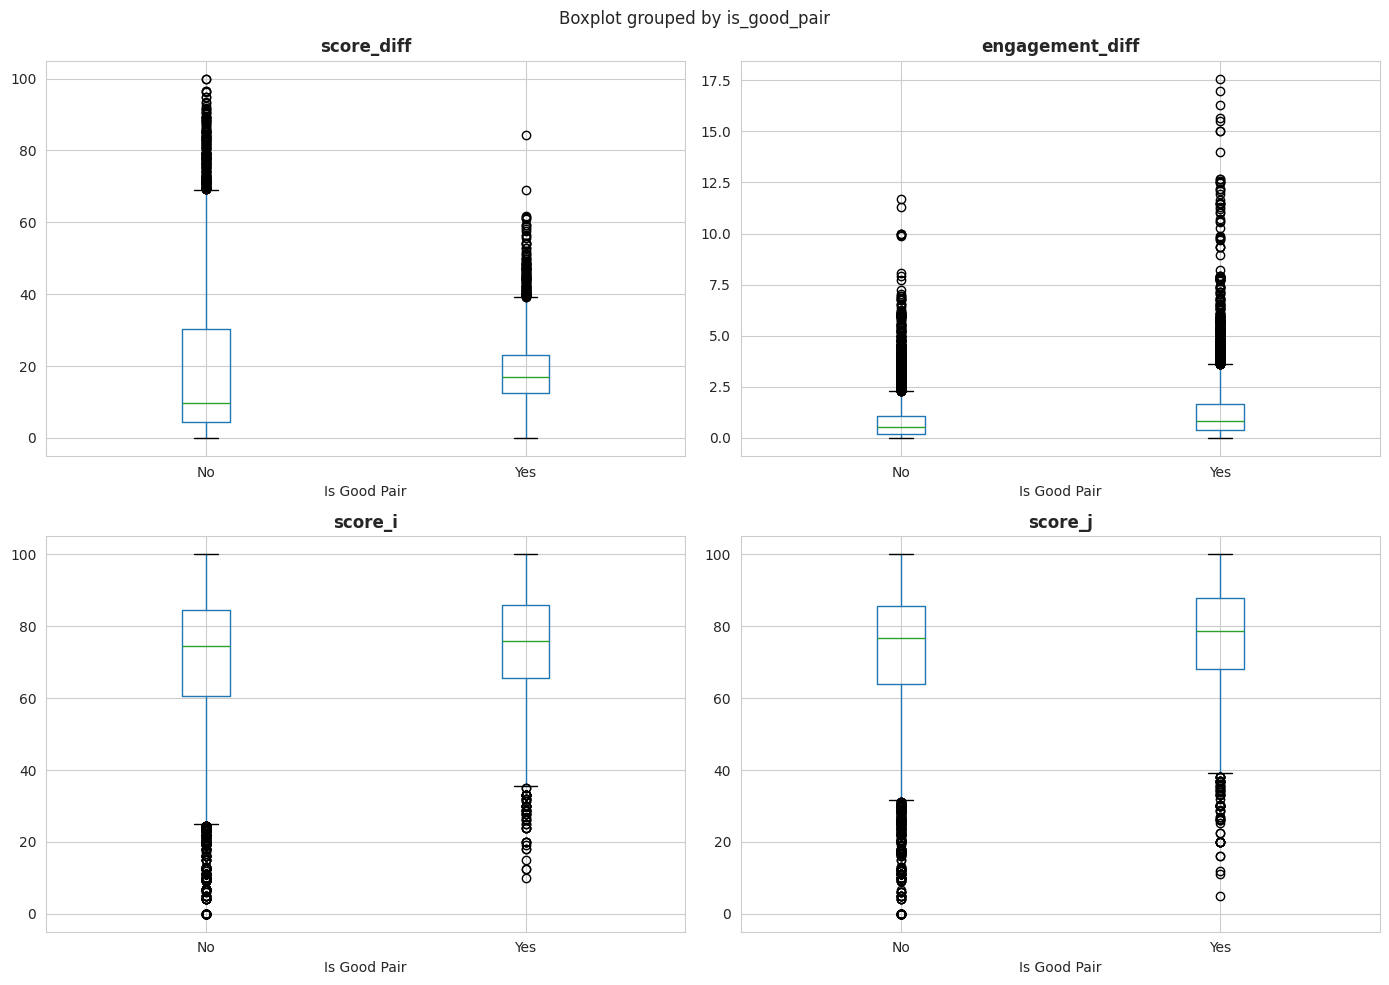


SCORE DISTRIBUTION ANALYSIS

Label rate by score bucket:
             is_good_pair complementarity_score             
                     mean                   min    max count
score_bucket                                                
0                   0.000                 0.211  0.266  4641
1                   0.000                 0.266  0.321  2407
2                   0.000                 0.321  0.376  2484
3                   0.000                 0.376  0.431  3099
4                   0.106                 0.431  0.486  4583
5                   1.000                 0.486  0.541  3635
6                   1.000                 0.541  0.596  1087
7                   1.000                 0.596  0.651   284
8                   1.000                 0.651  0.704    78
9                   1.000                 0.711  0.761     4

✓ Saved 22,302 labeled pairs to ../data/processed/pairs_labeled.csv

PAIR LABELING SUMMARY

Total pairs: 22,302
Positive pairs: 5,576 (25.0%)
Negati

In [1]:
"""
Pair Construction and Complementarity Labeling

This notebook creates student pairs and assigns complementarity labels.
"""

# %% Setup
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from labeling import (
    sample_pairs,
    label_pairs,
    create_binary_labels
)

sns.set_style("whitegrid")

# %% Load processed features
print("Loading processed data...")
df_features = pd.read_csv("../data/processed/student_features.csv")
topic_vectors = np.load("../data/processed/student_topic_vectors.npy")

print(f"✓ Loaded {len(df_features)} students")
print(f"✓ Loaded topic vectors: {topic_vectors.shape}")

# %% Sample pairs
student_ids = df_features['id_student'].values
pairs = sample_pairs(student_ids, max_pairs=50000, seed=42)

# %% Test different labeling methods
print("\n" + "="*60)
print("TESTING LABELING METHODS")
print("="*60 + "\n")

methods = ['topical', 'engagement', 'trajectory', 'combined']
label_results = {}

for method in methods:
    print(f"\n--- Testing {method} method ---")
    df_pairs = label_pairs(pairs, df_features, topic_vectors, label_method=method)
    label_results[method] = df_pairs.copy()
    
    print(f"Score distribution:")
    print(df_pairs['complementarity_score'].describe())

# %% Compare label distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, method in enumerate(methods):
    df = label_results[method]
    axes[i].hist(df['complementarity_score'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{method.title()} Method', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Complementarity Score')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(df['complementarity_score'].median(), color='red', 
                    linestyle='--', label=f'Median: {df["complementarity_score"].median():.2f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('../results/label_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# %% Choose best method (combined) and create binary labels
print("\n" + "="*60)
print("CREATING FINAL LABELS (COMBINED METHOD)")
print("="*60 + "\n")

df_pairs = label_results['combined'].copy()

# Test different thresholds
thresholds = [70, 75, 80]
for thresh in thresholds:
    df_test = create_binary_labels(df_pairs.copy(), threshold_percentile=thresh)
    print()

# Use 75th percentile
df_pairs = create_binary_labels(df_pairs, threshold_percentile=75)

# %% Visualize score vs binary labels
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot by binary label
df_pairs.boxplot(column='complementarity_score', by='is_good_pair', ax=axes[0])
axes[0].set_title('Complementarity Score by Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Is Good Pair')
axes[0].set_ylabel('Complementarity Score')
plt.sca(axes[0])
plt.xticks([1, 2], ['No', 'Yes'])

# Score distribution colored by label
axes[1].hist(df_pairs[df_pairs['is_good_pair']==0]['complementarity_score'], 
             bins=50, alpha=0.6, label='Negative', color='red')
axes[1].hist(df_pairs[df_pairs['is_good_pair']==1]['complementarity_score'], 
             bins=50, alpha=0.6, label='Positive', color='green')
axes[1].set_title('Score Distribution by Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Complementarity Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/binary_labels.png', dpi=300, bbox_inches='tight')
plt.show()

# %% Analyze pair characteristics
print("\n" + "="*60)
print("PAIR CHARACTERISTICS ANALYSIS")
print("="*60 + "\n")

# Compare positive vs negative pairs
comparison = df_pairs.groupby('is_good_pair')[
    ['score_diff', 'engagement_diff', 'score_i', 'score_j']
].mean()

print("Average characteristics:")
print(comparison)

# %% Visualize pair characteristics
features_to_plot = ['score_diff', 'engagement_diff', 'score_i', 'score_j']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    df_pairs.boxplot(column=feature, by='is_good_pair', ax=axes[i])
    axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Is Good Pair')
    plt.sca(axes[i])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.tight_layout()
plt.savefig('../results/pair_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

# %% Check class balance by percentile buckets
print("\n" + "="*60)
print("SCORE DISTRIBUTION ANALYSIS")
print("="*60 + "\n")

# Create score buckets
df_pairs['score_bucket'] = pd.cut(df_pairs['complementarity_score'], 
                                   bins=10, labels=False)

bucket_stats = df_pairs.groupby('score_bucket').agg({
    'is_good_pair': 'mean',
    'complementarity_score': ['min', 'max', 'count']
}).round(3)

print("Label rate by score bucket:")
print(bucket_stats)

# %% Save labeled pairs
output_file = Path("../data/processed/pairs_labeled.csv")
df_pairs.to_csv(output_file, index=False)
print(f"\n✓ Saved {len(df_pairs):,} labeled pairs to {output_file}")

# %% Summary
print("\n" + "="*60)
print("PAIR LABELING SUMMARY")
print("="*60 + "\n")

print(f"Total pairs: {len(df_pairs):,}")
print(f"Positive pairs: {df_pairs['is_good_pair'].sum():,} ({df_pairs['is_good_pair'].mean()*100:.1f}%)")
print(f"Negative pairs: {(1-df_pairs['is_good_pair']).sum():,} ({(1-df_pairs['is_good_pair']).mean()*100:.1f}%)")
print(f"\nComplementarity score range: [{df_pairs['complementarity_score'].min():.3f}, {df_pairs['complementarity_score'].max():.3f}]")
print(f"Mean score: {df_pairs['complementarity_score'].mean():.3f}")
print(f"Median score: {df_pairs['complementarity_score'].median():.3f}")

print("\n✓ Next step: Run 04_baselines.ipynb")